In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [73]:
_train_data = pd.read_csv("optdigits.tra", header=None)
_test_data = pd.read_csv("optdigits.tes", header=None)

train_data = _train_data.drop(columns=_train_data.columns[-1], axis=1)
train_labels = _train_data[_train_data.columns[-1:]]

test_data = _test_data.drop(columns=_test_data.columns[-1], axis=1)
test_labels = _test_data[_test_data.columns[-1:]]

train_features = train_data.to_numpy()
train_labels = train_labels.to_numpy()
train_features = np.concatenate((np.ones((train_data.shape[0], 1)), train_features), axis=1)
labels = np.unique(train_labels)

test_features = test_data.to_numpy()
test_labels = test_labels.to_numpy()
test_features = np.concatenate((np.ones((test_data.shape[0], 1)), test_features), axis=1)


In [74]:
def one_vs_all(decision, labels):
    decisions = []
    for label in labels:
        label_class = np.where(decision == label, 1, 0)
        decisions.append(label_class)
    return decisions


_train = one_vs_all(train_labels, labels)
_test = one_vs_all(test_labels, labels)

In [75]:
weights = []

def sigmoid(z):
        return 1 / (1 + np.exp(-z))


def loss(y, y_pred):
    losses = (y * np.log(y_pred)) + ((1 - y) * np.log(1 - y_pred))
    return -np.mean(losses)


def train(train_features, train_labels, test_features, test_labels, lam, alpha, max_epochs):
    weights = np.zeros((1, train_features.shape[1]))
    train_errors = []
    test_errors = []
    for epoch in range(max_epochs):
        wx = np.dot(train_features, weights.T)
        y_pred_train = sigmoid(wx)

        wx = np.dot(test_features, weights.T)
        y_pred_test = sigmoid(wx)

        dw = np.dot((y_pred_train - train_labels).T, train_features) * (1 / train_features.shape[0])

        delta = dw + (lam * weights)

        weights = weights - (alpha * delta)
        
        wx = np.dot(train_features, weights.T)
        y_pred_train = sigmoid(wx)
        
        wx = np.dot(test_features, weights.T)
        y_pred_test = sigmoid(wx)

        train_loss = loss(train_labels, y_pred_train)
        test_loss = loss(test_labels, y_pred_test)
        train_errors.append(train_loss)
        test_errors.append(test_loss)
    return weights, train_errors, test_errors


epochs = 200
_training_losses = np.empty((10, epochs))
_test_losses = np.empty((10, epochs))
for i in labels:
    weight, train_loss, test_loss = train(train_features, _train[i],
                                          test_features, _test[i], 0, 0.01,
                                          epochs)
    _training_losses[i, :] = train_loss
    _test_losses[i, :] = test_loss
    weights.append(weight)

training_losses = np.mean(_training_losses, axis=0)
testing_losses = np.mean(_test_losses, axis=0)

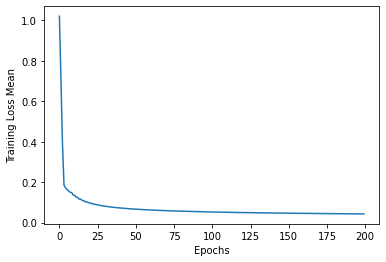

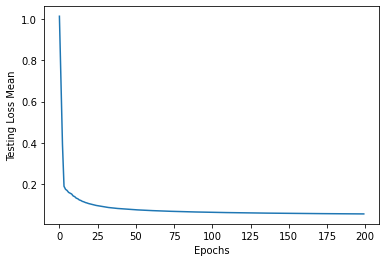

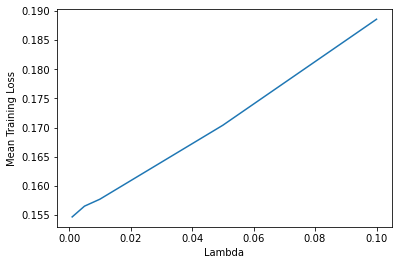

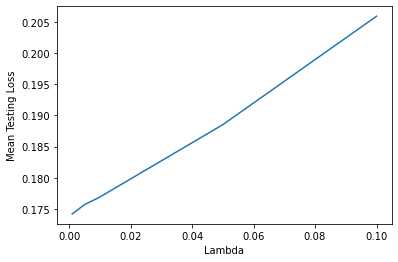

In [76]:
def predict(features_array_train, features_array_test, decision_train, decision_test,
            one_vs_all_class_weights):

    def _predict(features, weight):
        wx = np.dot(features, weight.T)
        y_pred = sigmoid(wx)
        return y_pred

    train_prediction_list = []
    for i in labels:
        prediction_i = _predict(features_array_train, one_vs_all_class_weights[i])
        train_prediction_list.append(prediction_i)

    train_prediction_array = np.asarray(train_prediction_list)
    train_preds = np.argmax(train_prediction_array, axis=0)
    # training_accuracy = accuracy_score(decision_train, train_preds)

    test_prediction_list = []
    for i in labels:
        prediction_i = _predict(features_array_test, one_vs_all_class_weights[i])
        test_prediction_list.append(prediction_i)

    test_prediction_array = np.asarray(test_prediction_list)
    test_preds = np.argmax(test_prediction_array, axis=0)
    # test_accuracy = accuracy_score(decision_test, test_preds)


plt.plot(range(epochs), training_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss Mean')
plt.show()

plt.plot(range(epochs), testing_losses)
plt.xlabel('Epochs')
plt.ylabel('Testing Loss Mean')
plt.show()

predict(train_features, test_features, train_labels, test_labels,
        weights)

lambdas = [0.001, 0.005, 0.01, 0.05, 0.1]

training_loss = []
test_loss = []

for lam in lambdas:
    _training_loss = []
    _testing_loss = []
    for i in labels:
        weight, train_loss, _test_loss = train(train_features, _train[i],
                                               test_features, _test[i], lam, 0.05,
                                               epochs)
        _training_loss.append(train_loss)
        _testing_loss.append(_test_loss)
    training_loss.append(np.mean(_training_loss))
    test_loss.append(np.mean(_testing_loss))

plt.plot(lambdas, training_loss)
plt.xlabel('Lambda')
plt.ylabel('Mean Training Loss')
plt.show()

plt.plot(lambdas, test_loss)
plt.xlabel('Lambda')
plt.ylabel('Mean Testing Loss')
plt.show()